In [3]:
from langgraph.graph import StateGraph, END

from models import MovieState
from nodes.classify import classify_query
from nodes.extract import extract_movie_name, check_movie_exists
from nodes.plot import get_dataset_plot, get_web_plot
from nodes.kg import kg_agent, kg_results_to_docs
from nodes.search import similarity_search
from nodes.rerank import hybrid_rerank
from nodes.generate import generate_answer, handle_invalid
from logger import get_logger

2026-02-03 14:24:05 - services.faiss_service - INFO - Initializing FAISS service...
2026-02-03 14:24:14 - services.faiss_service - INFO - Embeddings model loaded: sentence-transformers/all-MiniLM-L6-v2
2026-02-03 14:24:16 - services.faiss_service - INFO - FAISS index loaded from: D:\emerging\artifacts\movie_faiss_v3
2026-02-03 14:24:20 - services.faiss_service - INFO - Dataset loaded: D:\emerging\df1_cleaned.csv (34884 records)
2026-02-03 14:24:20 - services.tavily_service - INFO - Initializing Tavily service...
2026-02-03 14:24:20 - services.tavily_service - INFO - Tavily search client initialized
2026-02-03 14:24:21 - services.neo4j_service - INFO - Initializing Neo4j connection...
2026-02-03 14:24:23 - services.neo4j_service - INFO - Neo4j connected: neo4j+s://b7a7a14e.databases.neo4j.io
2026-02-03 14:24:23 - services.reranker_service - INFO - Initializing Reranker service...
2026-02-03 14:24:27 - services.reranker_service - INFO - CrossEncoder model loaded: cross-encoder/ms-marco-M

In [4]:
logger = get_logger(__name__)

In [5]:

def route_after_classification(state):
    """Route based on classified intent."""
    intent = state.get("intent")
    logger.info(f"Routing after classification: intent={intent}")
    
    if intent == "plot":
        return "similarity_search"  # Flow 1: Semantic Search
    elif intent == "movie_name":
        return "extract_movie_name"  # Flows 2 & 3: Specific Name
    elif intent == "query_search":
        return "kg_agent"  # Flow 4: Query/KG Search
    elif intent == "invalid":
        return "handle_invalid"
    return "kg_agent"


def route_after_extraction(state):
    """Route based on extracted movie name."""
    if state.get("movie_name"):
        logger.info(f"Movie name extracted: {state['movie_name']}")
        return "check_movie_exists"
    else:
        logger.warning("No movie name extracted, falling back to similarity search")
        return "similarity_search"


def route_movie_exists(state):
    """Route based on movie existence in dataset."""
    if state["movie_exists"]:
        logger.info("Movie exists in dataset, using dataset plot")
        return "get_dataset_plot"  # Flow 2: Existing in Dataset
    logger.info("Movie not in dataset, using web search")
    return "get_web_plot"  # Flow 3: Web Search

In [6]:
"""Build and compile the LangGraph workflow."""
logger.info("Building LangGraph workflow...")
    
graph = StateGraph(MovieState)

# Add all nodes
graph.add_node("classify_query", classify_query)
graph.add_node("extract_movie_name", extract_movie_name)
graph.add_node("check_movie_exists", check_movie_exists)
graph.add_node("get_dataset_plot", get_dataset_plot)
graph.add_node("get_web_plot", get_web_plot)
graph.add_node("kg_agent", kg_agent)
graph.add_node("kg_results_to_docs", kg_results_to_docs)
graph.add_node("hybrid_rerank", hybrid_rerank)
graph.add_node("similarity_search", similarity_search)
graph.add_node("generate_answer", generate_answer)
graph.add_node("handle_invalid", handle_invalid)
    
# Set entry point
graph.set_entry_point("classify_query")
    
# Edge 1: Classify -> (Route)
graph.add_conditional_edges(
        "classify_query",
    route_after_classification,
        {
            "similarity_search": "similarity_search",
            "extract_movie_name": "extract_movie_name",
            "kg_agent": "kg_agent",
            "handle_invalid": "handle_invalid"
        }
)
# Edge 2: Extract Name -> (Route Check or Fallback)
graph.add_conditional_edges(
        "extract_movie_name",
        route_after_extraction,
        {
            "check_movie_exists": "check_movie_exists",
            "similarity_search": "similarity_search"
        }
)
    
    # Edge 3: Check Exists -> (Route YES/NO)
graph.add_conditional_edges(
        "check_movie_exists",
        route_movie_exists,
        {
            "get_dataset_plot": "get_dataset_plot",
            "get_web_plot": "get_web_plot"
        }
    )
    
    # Plot paths -> similarity_search -> hybrid_rerank
graph.add_edge("get_dataset_plot", "similarity_search")
graph.add_edge("get_web_plot", "similarity_search")
graph.add_edge("similarity_search", "hybrid_rerank")
    
    # KG flow -> kg_results_to_docs -> hybrid_rerank
graph.add_edge("kg_agent", "kg_results_to_docs")
graph.add_edge("kg_results_to_docs", "hybrid_rerank")
    
    # Final Answer
graph.add_edge("hybrid_rerank", "generate_answer")
graph.add_edge("generate_answer", END)
graph.add_edge("handle_invalid", END)
    
    # Compile the graph
app = graph.compile()

2026-02-03 14:27:43 - __main__ - INFO - Building LangGraph workflow...


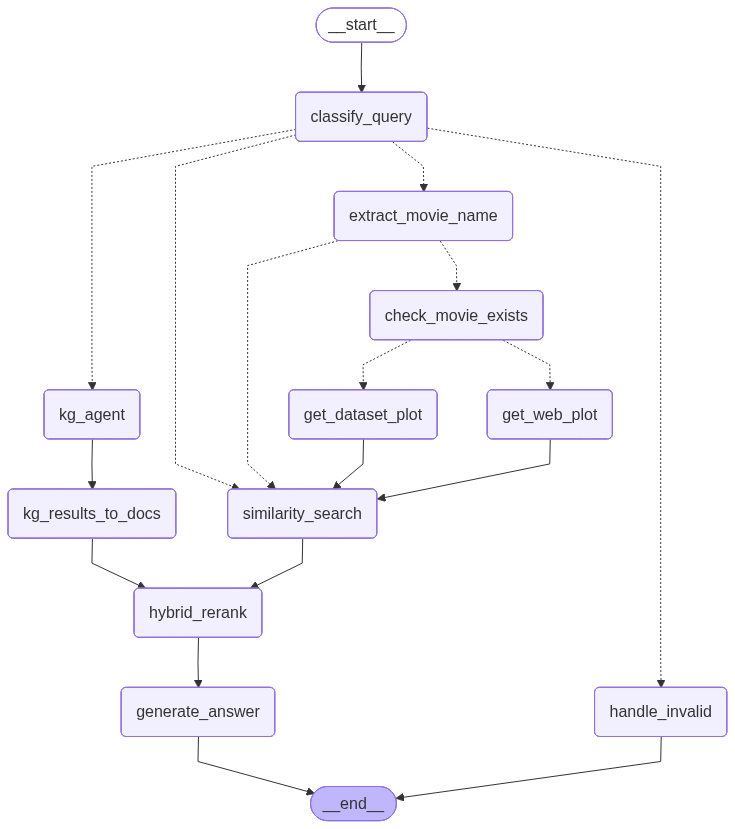

In [7]:
app